In [1]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#downcast for less memory usage 
cols_int16={
    'item_id': 'category',
    'dept_id': 'category',
    'cat_id': 'category',
    'store_id': 'category',
    'state_id': 'category',
    'sales': 'int16',
    'month': 'int8',
    'year': 'int16',
    'd': 'int16',
    'event_name_1': 'category',
    'event_type_1': 'category',
    'event_name_2': 'category',
    'event_type_2': 'category',
    'snap_CA': 'int8',
    'snap_TX': 'int8',
    'snap_WI': 'int8',
    'day': 'int8',
    'sell_price':'float32',
    'sales_lag1':'int16',
    'sales_lag2':'int16',
    'sales_lag3':'int16',
    'sales_lag4':'int16',
    'sales_lag5':'int16',
    'sales_lag6':'int16',
    'sales_lag7':'int16',
    'sales_lag14':'int16',
    'sales_lag21':'int16',
    'sales_lag28':'int16',
    'sales_lag35':'int16',
    'sales_lag30':'int16',
    'sales_lag31':'int16',
    'sales_lag60':'int16'
    }

df=pd.read_csv('modeling.csv',dtype=cols_int16)

In [4]:
df.id.head()

0    14370
1    14380
2    14390
3    14400
4    14410
Name: id, dtype: int16

In [5]:
'''we decoded the data for minimum memory usage and because 
i thought i'll be using an LSTM+embedding (which is very resource intensive)
now i'm decoding it back into categories because i'll be using catboost 
'''

import pickle as pkl 

with open('calendar_encoders.pkl','rb') as f : 
    le1=pkl.load(f)

with open('validation_le_encoders.pkl','rb') as f : 
    le2=pkl.load(f)
le=le1|le2

In [6]:
print(le)

{'event_name_1': LabelEncoder(), 'event_type_1': LabelEncoder(), 'event_name_2': LabelEncoder(), 'event_type_2': LabelEncoder(), 'id': LabelEncoder(), 'item_id': LabelEncoder(), 'dept_id': LabelEncoder(), 'cat_id': LabelEncoder(), 'store_id': LabelEncoder(), 'state_id': LabelEncoder()}


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int16  
 1   item_id       int16  
 2   dept_id       int8   
 3   cat_id        int8   
 4   store_id      int8   
 5   state_id      int8   
 6   wm_yr_wk      int16  
 7   day           int8   
 8   month         int8   
 9   year          int16  
 10  d             int16  
 11  event_name_1  int8   
 12  event_type_1  int8   
 13  event_name_2  int8   
 14  event_type_2  int8   
 15  snap_CA       int8   
 16  snap_TX       int8   
 17  snap_WI       int8   
 18  weekday_cos   float64
 19  weekday_sin   float64
 20  sales         int16  
 21  sell_price    float32
dtypes: float32(1), float64(2), int16(6), int8(13)
memory usage: 2.4 GB


In [8]:

for col in le : 
    df[col]=pd.Series(le[col].inverse_transform(df[col])).astype('category')


In [9]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,wm_yr_wk,day,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,weekday_cos,weekday_sin,sales,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11101,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,9.58
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,11101,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,3.97
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,11101,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,2.97
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,11101,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,4.34
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,11101,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,2.98


In [19]:
import gc 
gc.collect()

0

<Figure size 1200x600 with 0 Axes>

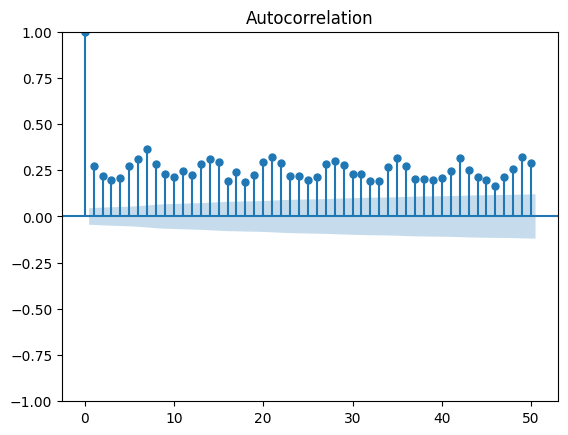

In [11]:
from statsmodels.graphics.tsaplots import plot_acf


sales_series = df[df['store_id']=='TX_2']
sales_series = sales_series[sales_series['item_id']=='HOBBIES_1_004']['sales']

# Now sales_series is a Series over time
plt.figure(figsize=(12,6))
plot_acf(sales_series, lags=50)
plt.show()


In [12]:
'''in order to use gradient boosters for forecasting here we need to transform time series data 
to supervised data , so we need to add past data of time sensetive features that have impact on the sales (A.K.A lag)'''

lag=[1,2,3,4,5,6,7,14,21,28,35,30,31,60] 

for l in lag : 
    df[f'sales_lag{l}']=df.groupby(['store_id','item_id'])['sales'].shift(l).fillna(0).astype('int16')

/tmp/ipykernel_938433/2632388522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'sales_lag{l}']=df.groupby(['store_id','item_id'])['sales'].shift(l).fillna(0).astype('int16')
/tmp/ipykernel_938433/2632388522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'sales_lag{l}']=df.groupby(['store_id','item_id'])['sales'].shift(l).fillna(0).astype('int16')
/tmp/ipykernel_938433/2632388522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

In [20]:
df.to_csv('modeling.csv',header=True,index=False)

In [ ]:
df.drop(['wm_yr_wk','id'],axis=1,inplace=True)

In [17]:
df.head()

,item_id,dept_id,cat_id,store_id,state_id,day,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,weekday_cos,weekday_sin,sales,sell_price,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,sales_lag14,sales_lag21,sales_lag28,sales_lag35,sales_lag30,sales_lag31,sales_lag60
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,9.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,3.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,2.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,4.34,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,29,1,2011,1,No event,No event,No event,No event,0,0,0,-0.222521,-0.974928,0,2.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = df
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sales']]
test = data[data['d']>=1942][['id','d','sales']]
eval_preds = test['sales']
valid_preds = valid['sales']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            int64   
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   wm_yr_wk      int64   
 7   day           int8    
 8   month         int8    
 9   year          int16   
 10  d             int16   
 11  event_name_1  category
 12  event_type_1  category
 13  event_name_2  category
 14  event_type_2  category
 15  snap_CA       int8    
 16  snap_TX       int8    
 17  snap_WI       int8    
 18  weekday_cos   float64 
 19  weekday_sin   float64 
 20  sales         int16   
 21  sell_price    float32 
dtypes: category(9), float32(1), float64(2), int16(3), int64(2), int8(5)
memory usage: 3.1 GB


In [ ]:
from lightgbm import LGBMRegressor
import joblib

#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sales',axis=1), df[df['d']<1914]['sales']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sales',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sales']
    X_test = df[df['d']>=1942].drop('sales',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()